In [1]:
from torchvision import transforms, datasets
import torch as torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# params
image_size = 64
bs=256
std,mean = (0.5, 0.5, 0.5),(0.5, 0.5, 0.5) #normalization of image
real_label=1
fake_label=0
lr=0.0002
beta=0.5
nz=100

In [4]:
compose = transforms.Compose([transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize(std, mean),
                              ])

In [5]:
cifar = datasets.CIFAR10(root='cifar10', download=True, train=True, transform=compose)
dataset = [ds for ds in tqdm(cifar) if ds[1] == 5]

Files already downloaded and verified


In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True,)

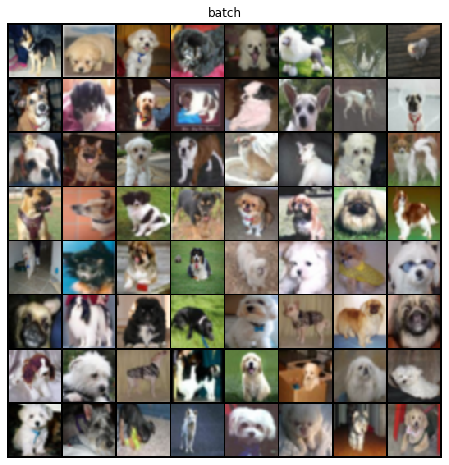

In [7]:
batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("batch")
plt.imshow(vutils.make_grid(batch[0][:64], padding=2, normalize=True).cpu().permute(1,2,0))

In [8]:
def imshow(img, std, mean):
    img = img.permute(1,2,0).cpu()
    img = img * torch.tensor(std) + torch.tensor(mean)
    img = np.clip(img, 0, 1)
    plt.imshow(img)

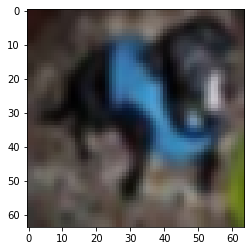

In [9]:
imshow(dataset[0][0],std,mean)

In [20]:
def weights_init(m):
    module_name = m.__class__.__name__
    if 'Conv' in module_name:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in module_name:
      #https://discuss.pytorch.org/t/weight-initialization-for-batchnorm-in-dcgan-tutorial/32351
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
def printShapes(model, input):
    a = input
    print(a.shape)
    for l in model.layers:
        if 'Conv' in l.__class__.__name__:
            a = l(a)
            print(a.shape)

In [37]:
def convT_bn(in_channels,
             out_channels,
             kernel_size,
             stride, padding, 
             bias=False, 
             act=nn.ReLU(True)):
    layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)]
    layers.append(nn.BatchNorm2d(out_channels))
    layers.append(act)
    return layers

#from ConvTranspose2d doc:
#Hout​=(Hin​−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
#p=((Hin-1)*s+k-Hout)/2
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
          *convT_bn(nz,512,4,1,0), #p=((1-1)*2+4-4)/2 => p=0
          nn.Dropout(0.5),
          *convT_bn(512, 256,4,2,1),
          nn.Dropout(0.5),
          *convT_bn(256,128,4,2,1),
          nn.Dropout(0.5),
          *convT_bn(128,64,4,2,1),
          nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
          nn.Tanh()
        )
    def forward(self, input):
        return self.layers(input)
        
g = Generator()

noise = torch.randn(bs, nz, 1, 1)
printShapes(g,noise)   

torch.Size([256, 100, 1, 1])
torch.Size([256, 512, 4, 4])
torch.Size([256, 256, 8, 8])
torch.Size([256, 128, 16, 16])
torch.Size([256, 64, 32, 32])
torch.Size([256, 3, 64, 64])


In [38]:
def conv_bn(in_channels,
            out_channels,
            kernel_size,
            stride, padding, 
            bias=False, 
            act=nn.LeakyReLU(0.2,True)):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)]
    layers.append(nn.BatchNorm2d(out_channels))
    layers.append(act)
    return layers


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
          nn.Conv2d(3, 64, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2,True),
          *conv_bn(64,128,4,2,1),
          *conv_bn(128,256,4,2,1), 
          *conv_bn(256,512,4,2,1),
          nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        )
    def forward(self, input):
        return self.layers(input)


d = Discriminator()
abatch = next(iter(dataloader))
printShapes(d,abatch[0])

torch.Size([256, 3, 64, 64])
torch.Size([256, 64, 32, 32])
torch.Size([256, 128, 16, 16])
torch.Size([256, 256, 8, 8])
torch.Size([256, 512, 4, 4])
torch.Size([256, 1, 1, 1])


In [39]:
def fit(epochs, iterator, optimizer_g, optimizer_d,discriminator,generator):
    criterion = nn.BCEWithLogitsLoss()
    i=1
    generator.train()
    discriminator.train()
    for epoch in tqdm(range(epochs)):
        for batch in tqdm(iterator, leave=False):
            bs=batch[1].shape[0]
            # Train disciminator
            # Train with real samples
            optimizer_d.zero_grad()
            y=torch.full_like(batch[1], real_label, device=device).float() #real_label
            yhat=discriminator(batch[0].to(device)).view(-1)
            loss_real=criterion(yhat,y)
            loss_real.backward()
            Dx = yhat.sigmoid().mean().item()
            # Train with fake samples
            noise = torch.randn(bs, nz, 1, 1, device=device)
            fake_images = generator(noise)
            y=torch.full_like(batch[1], fake_label,device=device).float() #fake_label
            yhat=discriminator(fake_images.detach()).view(-1)
            loss_fake=criterion(yhat,y)
            loss_fake.backward()

            optimizer_d.step()
            loss_d = loss_real + loss_fake
            DGz = yhat.sigmoid().mean().item()

            # Train generator
            optimizer_g.zero_grad()
            y=torch.full_like(batch[1], real_label, device=device).float() #generator must create real images
            yhat=discriminator(fake_images).view(-1)
            loss_g = criterion(yhat,y)
            loss_g.backward()
            optimizer_g.step()
            writer.add_scalars('losses', {'loss_d':loss_d.item(),
                                        'loss_g':loss_g.item()}, i)

            writer.add_scalars('output', {'D(x)':Dx,
                                        'D(G(z))':DGz}, i)
            i+=1

In [40]:
generator = nn.DataParallel(Generator()).to(device)
generator.apply(weights_init)
discriminator = nn.DataParallel(Discriminator()).to(device)
discriminator.apply(weights_init)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta, 0.999))

In [ ]:
writer = SummaryWriter('mylogs/baseline_dropout/',flush_secs=1)
fit(300, dataloader, optimizer_g, optimizer_d, discriminator, generator)

In [28]:
#%load_ext tensorboard
#%reload_ext tensorboard

In [29]:
#%tensorboard --logdir mylogs

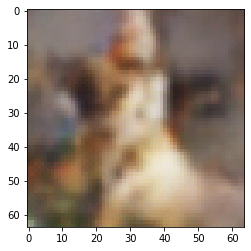

In [36]:
generator.eval()
with torch.no_grad():
    noise = torch.randn(1, nz, 1, 1, device=device)
    fake_images = generator(noise)
imshow(fake_images[0],std,mean)